# Question 1: MNIST dataset

In [1]:
# Load MNIST dataset
from sklearn.datasets import fetch_openml
import numpy as np

# Load the dataset
mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

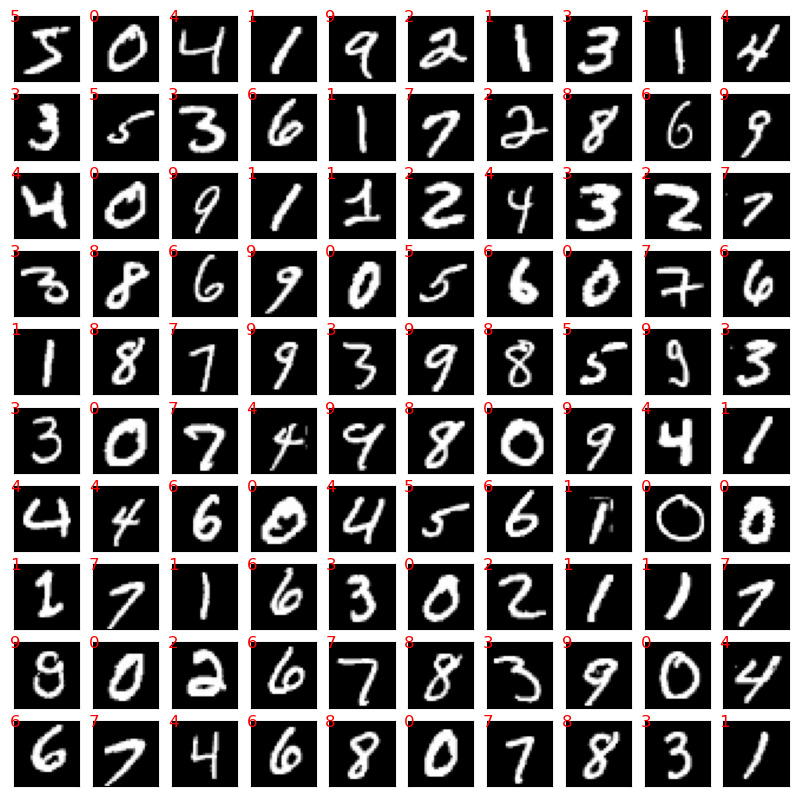

In [2]:
# Display each digit with labels
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i].reshape(28, 28), cmap=cm.Greys_r)
    ax.text(0, 0, str(y_train[i]), color='red', fontsize=12, ha='center', va='center')
plt.show()


In [3]:
# Use PCA to retrieve the first and second principal components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Output explained variance ratio
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

Explained variance ratio: [0.09704664 0.07095924]


<Figure size 800x600 with 0 Axes>

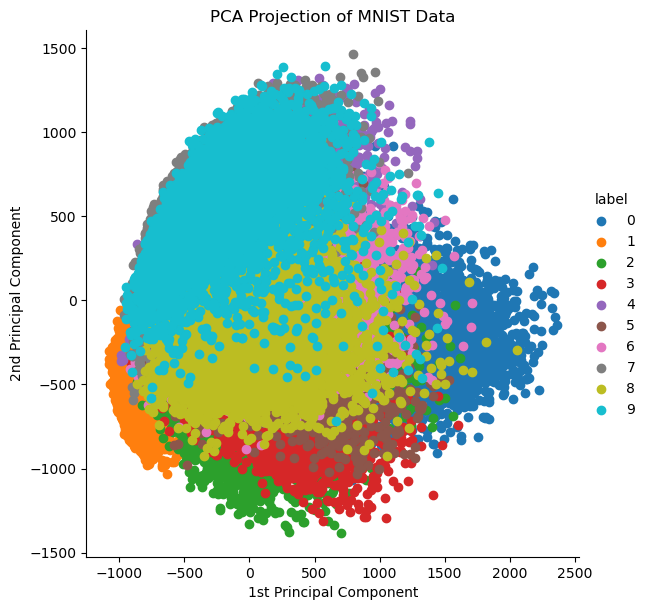

In [4]:
# Plot projections on a 1D hyperplane

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Combine the PCA-transformed data with the labels
pca_data = np.vstack((X_train_pca.T, y_train)).T

# Create a DataFrame with the combined data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))

# Ensure the labels are sorted from 0 to 9
pca_df['label'] = pca_df['label'].astype(int)
pca_df = pca_df.sort_values(by='label')

# Create the scatter plot using seaborn's FacetGrid
plt.figure(figsize=(8, 6))
sn.FacetGrid(pca_df, hue="label", height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('PCA Projection of MNIST Data')
plt.show()

In [49]:
# Use incremental PCA to reduce dimensionality to 154 dimensions
from sklearn.decomposition import IncrementalPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
X_train_reduced = inc_pca.transform(X_train)
X_train_recovered = inc_pca.inverse_transform(X_train_reduced)

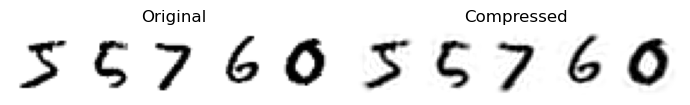

In [51]:
# Display the original and compressed digits from X_recovered
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2000], X_train_recovered[::2000])):
#for idx, X in enumerate((X_train[::2000], X_train_reduced[::2000])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for col in range(5):
        plt.imshow(X[col].reshape(28, 28), cmap="binary",
                   vmin=0, vmax=255, extent=(col, col + 1, 0, 1))
        plt.axis([0, 5, 0, 1])
        plt.axis("off")
plt.tight_layout()
plt.show()


# Question 2: Swiss Roll Dataset

In [7]:
# Generate Swiss Roll dataset

from sklearn.datasets import make_swiss_roll
X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

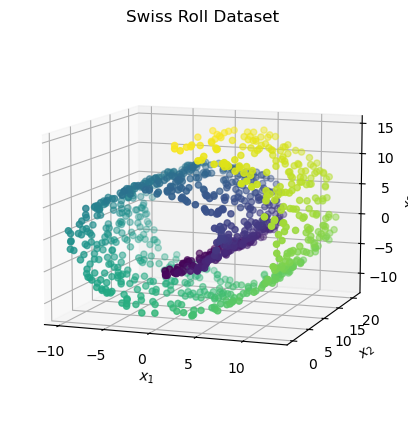

In [8]:
# Plot the Swiss Roll dataset
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=plt.cm.viridis)
ax.view_init(10, -70)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
plt.title('Swiss Roll Dataset')
plt.show()

In [52]:
# Use kPCA with linear kernel, rbf kernel, and sigmoid kernel
from sklearn.decomposition import KernelPCA

lin_kpca = KernelPCA(kernel = "linear")
rbf_kpca = KernelPCA(kernel = "rbf", gamma=0.04)
#sig_kpca = KernelPCA(kernel= "sigmoid", gamma=0.04, coef0=1)
sig_kpca = KernelPCA(kernel= "sigmoid", gamma=1e-3, coef0=1)

kernel_pcas = ((lin_kpca, "Linear kernel"),
               (rbf_kpca, rf"RBF kernel, $\gamma={rbf_kpca.gamma}$"),
               (sig_kpca, rf"Sigmoid kernel, $\gamma={sig_kpca.gamma}, r={sig_kpca.coef0}$"))


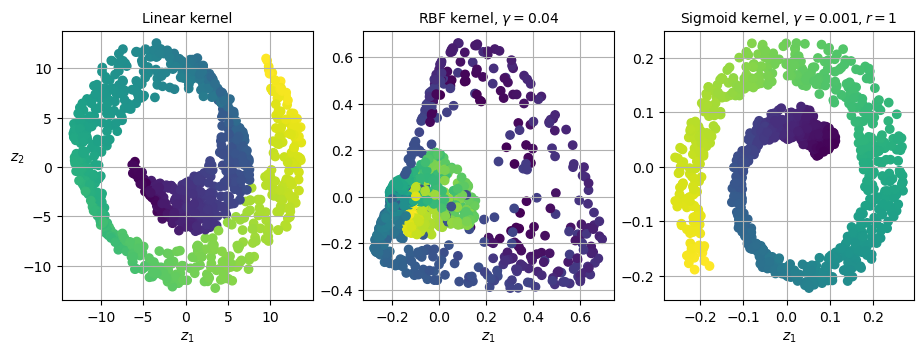

In [53]:
# Plot kPCA results 
plt.figure(figsize=(11, 3.5))
for idx, (kpca, title) in enumerate(kernel_pcas):
    kpca.n_components = 2
    kpca.random_state = 42
    X_swiss_reduced = kpca.fit_transform(X_swiss)

    plt.subplot(1, 3, idx + 1)
    plt.title(title, fontsize=10)
    plt.scatter(X_swiss_reduced[:, 0], X_swiss_reduced[:, 1], c=t, cmap=plt.cm.viridis)
    plt.xlabel("$z_1$")
    if idx == 0:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)
    
plt.show()

In [58]:
# Apply Logistic Regression for classification using kPCA and sigmoid kernel
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression(max_iter=2000))
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["linear","rbf","sigmoid"]
}]

# Discretize the target variable into 10 bins
from sklearn.preprocessing import KBinsDiscretizer

kbins = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# Discretize the target variable into 10 bins and convert to integer type for classification
t_discrete = kbins.fit_transform(t.reshape(-1, 1)).astype(int).ravel()

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_swiss, t_discrete)
#grid_search.fit(X_swiss, t)

# Output the best parameters
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Parameters: {'kpca__gamma': 0.03, 'kpca__kernel': 'linear'}
Best Score: 0.8709218200236163


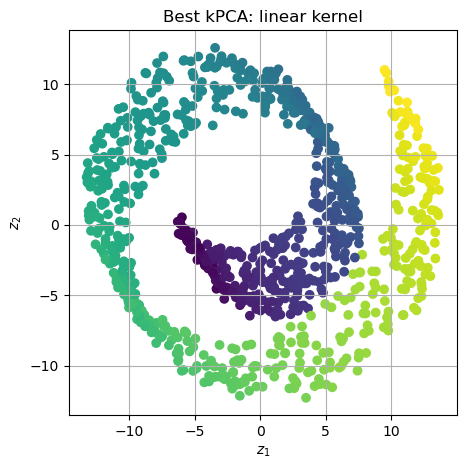

In [59]:
# Use best parameters from grid_search and plot
best_params = {key.split('__')[1]: value for key, value in grid_search.best_params_.items()}
best_kpca = KernelPCA(n_components=2, **best_params)
X_reduced = best_kpca.fit_transform(X_swiss)

plt.figure(figsize=(5, 5))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.viridis)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.title(f"Best kPCA: {best_params['kernel']} kernel")
plt.grid(True)
plt.show()

Mean Accuracy: 0.300995606384828
Standard Deviation: 0.003339899945519013
Scores: [0.30538922 0.2972973  0.3003003 ]


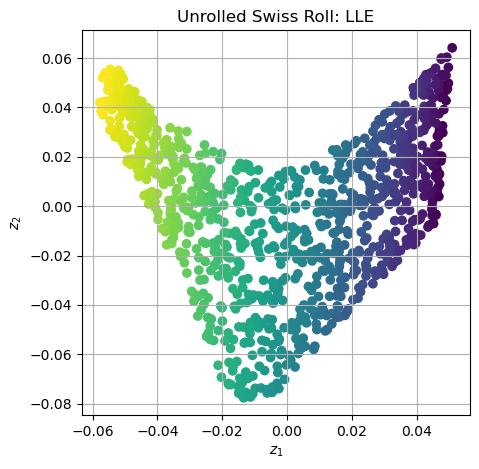

In [60]:
# Use lle for dimensionality reduction
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_swiss_unrolled = lle.fit_transform(X_swiss)

# Use logistic regression for classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_reg = LogisticRegression(max_iter=2000)
scores = cross_val_score(log_reg, X_swiss_unrolled, t_discrete, cv=3)
print(f"Mean Accuracy: {scores.mean()}")
print(f"Standard Deviation: {scores.std()}")
print(f"Scores: {scores}")

# Plot the unrolled Swiss Roll dataset
plt.figure(figsize=(5, 5))
plt.scatter(X_swiss_unrolled[:, 0], X_swiss_unrolled[:, 1], c=t, cmap=plt.cm.viridis)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.title("Unrolled Swiss Roll: LLE")
plt.grid(True)
plt.show()